In [46]:
import os
import torch
import pickle
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [47]:
# balanced_labels
def binary_one_hot(labels):
    # Converts [1, 0, 0, 0, 0] -> [1, 0], [0, 1, 0, 0, 0] -> [0, 1]
    first = labels[:, 0]
    output_array = np.zeros((labels.shape[0], 2))
    output_array[first == 1, 0] = 1
    output_array[first != 1, 1] = 1
    return output_array

def rebalance_data(data, labels, subjects, desired_distribution=None):
    """
    Rebalance the dataset so that each class has an equal number of samples or follow a desired distribution.
    
    Parameters:
        data (numpy.ndarray or list): Input data array.
        labels (numpy.ndarray or list): Corresponding labels for the data.
        desired_distribution (dict or None): A dictionary specifying the desired proportion of each class, 
                                             e.g., {0: 0.4, 1: 0.4, 2: 0.2}. 
                                             If None, all classes will have equal proportion.

    Returns:
        balanced_data (list): Rebalanced dataset.
        balanced_labels (list): Rebalanced labels.
    """
    # Ensure input is numpy array for ease of manipulation
    # If y_pred is in one-hot encoded format, convert it to class indices
    if len(np.array(labels).shape) > 1:
        labels = torch.argmax(torch.tensor(labels), dim=1).numpy()
    data = np.array(data)
    labels = np.array(labels)
    
    # Count the number of samples per class
    label_counts = Counter(labels)
    
    # Determine the minimum class size or calculate based on desired distribution
    if desired_distribution is None:
        # Equal proportions for each class
        min_class_size = min(label_counts.values())
        desired_class_counts = {label: min_class_size for label in label_counts}
    else:
        total_samples = len(labels)
        # Calculate the number of samples desired for each class based on the given proportions
        desired_class_counts = {label: int(total_samples * proportion) for label, proportion in desired_distribution.items()}
    
    # Rebalance the dataset
    balanced_data = []
    balanced_labels = []
    balanced_subjects = []
    
    for label, count in label_counts.items():
        # Get indices of all samples for the current label
        label_indices = np.where(labels == label)[0]
        
        if desired_class_counts[label] < count:
            # Undersample: Randomly select the desired number of samples for the current label
            selected_indices = np.random.choice(label_indices, size=desired_class_counts[label], replace=False)
        else:
            # Oversample: Randomly select with replacement to reach the desired number of samples
            selected_indices = np.random.choice(label_indices, size=desired_class_counts[label], replace=True)
        
        # Add the selected data and labels to the balanced lists
        balanced_data.extend(data[selected_indices])
        balanced_labels.extend(labels[selected_indices])
        balanced_subjects.extend(subjects[selected_indices])
    
    return np.array(balanced_data), np.array(balanced_labels), np.array(balanced_subjects)

In [48]:
class CustomNN(nn.Module):
    def __init__(self, input_shape, num_classes, hidden_layers=[64, 32], activation_fn=nn.ReLU):
        super(CustomNN, self).__init__()
        self.layers = nn.ModuleList()

        if len(input_shape) == 1:  # Flat input (samples, 60)
            prev_dim = input_shape[0]
            for hidden_dim in hidden_layers:
                self.layers.append(nn.Linear(prev_dim, hidden_dim))
                self.layers.append(activation_fn())
                prev_dim = hidden_dim
            self.layers.append(nn.Linear(prev_dim, num_classes))

        elif len(input_shape) > 1:  # 3D input (samples, 3, 300)
            self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
            self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
            conv_out_dim = 32 * 300  # Flatten the output of the convolutional layers
            prev_dim = conv_out_dim
            for hidden_dim in hidden_layers:
                self.layers.append(nn.Linear(prev_dim, hidden_dim))
                self.layers.append(activation_fn())
                prev_dim = hidden_dim
            self.layers.append(nn.Linear(prev_dim, num_classes))

    def forward(self, x):
        if x.dim() == 2:  # Flat input (samples, 60)
            for layer in self.layers:
                x = layer(x)
            return x
        elif x.dim() == 3:  # 3D input (samples, 3, 300)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)  # Flatten for fully connected layers
            for layer in self.layers:
                x = layer(x)
            return x


def test_nn(data, labels, subjects, epochs=50, lr=0.001, test_size=0.2, groups_split=True, multiclass=True, rebalance=True):
    
    if len(np.array(labels).shape) > 1:
        labels = torch.argmax(torch.tensor(labels), dim=1).numpy()
    if not multiclass:
        labels = (labels > 0).astype(int)
        if rebalance:
            data, labels, subjects = rebalance_data(data, labels, subjects)
    
    # Split the data using GroupShuffleSplit to avoid data leakage across patients
    if groups_split:
        gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
        train_idx, test_idx = next(gss.split(data, labels, groups=subjects))
    else:
        # Use regular train_test_split if groups_split is False
        train_idx, test_idx = train_test_split(
            range(len(data)), test_size=test_size, random_state=42, stratify=labels
        )

    X_train, X_test = data[train_idx], data[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)

    input_shape = X_train.shape[1:]

    # Initialize the model, specifying input size and number of classes
    input_shape = X_train.shape[1:] 
    num_classes = len(torch.unique(y_train))
    model = CustomNN(input_shape=input_shape, num_classes=num_classes, hidden_layers=[128, 64, 64, 64, 32], activation_fn=nn.ReLU)
    criterion = nn.CrossEntropyLoss()

    # Now optimizer will receive model parameters correctly
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Step 5: Create DataLoader for batch training
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Training loop
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # Calculate accuracy for this batch
            _, predicted = torch.max(outputs, 1)  # Get class with highest score
            correct_predictions += (predicted == labels).sum().item()  # Count correct predictions
            total_predictions += labels.size(0)  # Count total samples in batch

    
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # Compute epoch-level training accuracy
    training_accuracy = correct_predictions / total_predictions
    print(f"Training accuracy: {training_accuracy}")

    # Evaluate the model
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Display the confusion matrix as a heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Analyze major errors by identifying misclassifications
    total_samples_per_class = np.sum(conf_matrix, axis=1)
    error_counts = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)  # Errors per class
    error_rates = error_counts / total_samples_per_class
    major_errors = np.argsort(error_rates)[::-1]  # Sort in descending order of errors

    print("\nMajor errors occur in the following classes (sorted):")
    for i, cls in enumerate(major_errors):
        print(f"Class {cls}: {error_rates[cls]} misclassified samples")
        
    return model

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:15,  1.77s/it]

Epoch 1/10, Loss: 0.782722941683222


 20%|██        | 2/10 [00:03<00:14,  1.83s/it]

Epoch 2/10, Loss: 0.710530882741868


 30%|███       | 3/10 [00:05<00:12,  1.81s/it]

Epoch 3/10, Loss: 0.6789965376293977


 40%|████      | 4/10 [00:07<00:10,  1.83s/it]

Epoch 4/10, Loss: 0.6565540910633078


 50%|█████     | 5/10 [00:08<00:08,  1.77s/it]

Epoch 5/10, Loss: 0.6430244434976693


 60%|██████    | 6/10 [00:10<00:07,  1.76s/it]

Epoch 6/10, Loss: 0.6316284637618584


 70%|███████   | 7/10 [00:12<00:05,  1.75s/it]

Epoch 7/10, Loss: 0.6229641728337683


 80%|████████  | 8/10 [00:14<00:03,  1.76s/it]

Epoch 8/10, Loss: 0.6152298175177332


 90%|█████████ | 9/10 [00:16<00:01,  1.80s/it]

Epoch 9/10, Loss: 0.6127866982114806


100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

Epoch 10/10, Loss: 0.599530152128626
Training accuracy: 0.7493943064809206
Test Accuracy: 0.7411
Confusion Matrix:
[[2113  147    8    1    0]
 [ 466  252   17    4    0]
 [ 105   52   60   15    0]
 [  18    5   15   22    0]
 [   0    0    0    2    1]]


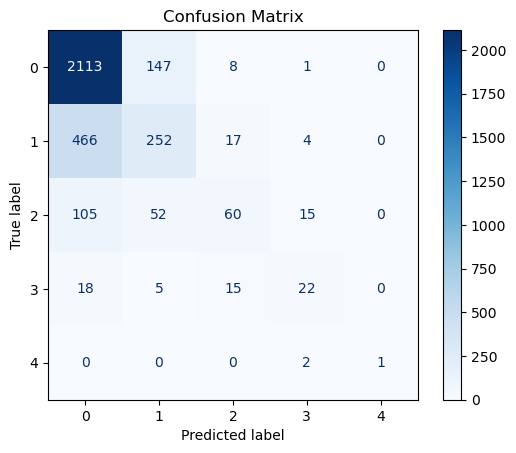


Major errors occur in the following classes (sorted):
Class 2: 0.7413793103448276 misclassified samples
Class 4: 0.6666666666666666 misclassified samples
Class 1: 0.6589986468200271 misclassified samples
Class 3: 0.6333333333333333 misclassified samples
Class 0: 0.06875275451740855 misclassified samples


In [49]:
# data_dir = r"fft_files\10s_window_all_scores_threshold_1"
# data_dir = r"fft_files\10s_multiclass_threshold_1"
# data_dir = r"fft_files\10s_all_multi_threshold_0"
data_dir = r"fft_files\10s_multi_threshold_1_all_tasks"
# data_dir = r"fft_files\10s_multi_threshold_0_no_1"

# Load the data
fft_features = pickle.load(open(os.path.join(data_dir, 'WindowsFFT.p'), 'rb'))   # (n_windows, n_features)
all_labels = pickle.load(open(os.path.join(data_dir, 'WindowsLabels.p'), 'rb'))      # (n_windows,) or (n_windows, n_labels)
subjects = groups = pickle.load(open(os.path.join(data_dir, 'WindowsSubjects.p'), 'rb'))    # (n_windows,)
# balanced_labels = np.delete(balanced_labels, 1, 1)  # delete second column of labels
model_multi = test_nn(fft_features, all_labels, subjects, epochs=10, lr=0.001, test_size=0.2, groups_split=False, multiclass=True)


 10%|█         | 1/10 [00:01<00:09,  1.09s/it]

Epoch 1/10, Loss: 0.6309541389058455


 20%|██        | 2/10 [00:01<00:07,  1.02it/s]

Epoch 2/10, Loss: 0.5827334719965357


 30%|███       | 3/10 [00:03<00:06,  1.00it/s]

Epoch 3/10, Loss: 0.5525741451725537


 40%|████      | 4/10 [00:04<00:06,  1.03s/it]

Epoch 4/10, Loss: 0.5437428007714997


 50%|█████     | 5/10 [00:05<00:05,  1.09s/it]

Epoch 5/10, Loss: 0.5253683935031007


 60%|██████    | 6/10 [00:06<00:04,  1.13s/it]

Epoch 6/10, Loss: 0.5295141935348511


 70%|███████   | 7/10 [00:07<00:03,  1.11s/it]

Epoch 7/10, Loss: 0.5102518593252395


 80%|████████  | 8/10 [00:08<00:02,  1.13s/it]

Epoch 8/10, Loss: 0.5100466574481095


 90%|█████████ | 9/10 [00:09<00:01,  1.14s/it]

Epoch 9/10, Loss: 0.49276074617525784


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]

Epoch 10/10, Loss: 0.4907686426717802
Training accuracy: 0.7586790855207451
Test Accuracy: 0.7620
Confusion Matrix:
[[797 237]
 [255 778]]


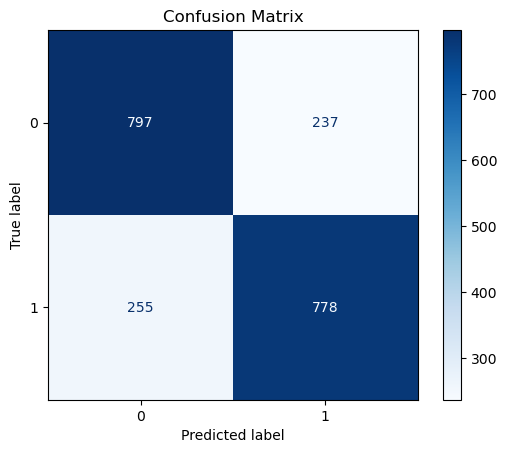


Major errors occur in the following classes (sorted):
Class 1: 0.2468538238141336 misclassified samples
Class 0: 0.22920696324951645 misclassified samples


In [42]:
# data_dir = r"fft_files\10s_window_all_scores_threshold_1"
# data_dir = r"fft_files\10s_multiclass_threshold_1"
# data_dir = r"fft_files\10s_all_multi_threshold_0"
data_dir = r"fft_files\10s_multi_threshold_1_all_tasks"
# data_dir = r"fft_files\10s_multi_threshold_0_no_1"

# Load the data
fft_features = pickle.load(open(os.path.join(data_dir, 'WindowsFFT.p'), 'rb'))   # (n_windows, n_features)
all_labels = pickle.load(open(os.path.join(data_dir, 'WindowsLabels.p'), 'rb'))      # (n_windows,) or (n_windows, n_labels)
subjects = groups = pickle.load(open(os.path.join(data_dir, 'WindowsSubjects.p'), 'rb'))    # (n_windows,)
# balanced_labels = np.delete(balanced_labels, 1, 1)  # delete second column of labels
model_binary_full = test_nn(fft_features, all_labels, subjects, epochs=10, lr=0.001, test_size=0.2, groups_split=False, multiclass=False)


Epoch 1/100, Loss: 0.6975555419921875
Epoch 2/100, Loss: 0.6727781891822815
Epoch 3/100, Loss: 0.6502791047096252
Epoch 4/100, Loss: 0.6299456357955933
Epoch 5/100, Loss: 0.611911416053772
Epoch 6/100, Loss: 0.5958946347236633
Epoch 7/100, Loss: 0.5815359950065613
Epoch 8/100, Loss: 0.5686657428741455
Epoch 9/100, Loss: 0.5570744276046753
Epoch 10/100, Loss: 0.5465773344039917
Epoch 11/100, Loss: 0.5369981527328491
Epoch 12/100, Loss: 0.5282099843025208
Epoch 13/100, Loss: 0.5200902819633484
Epoch 14/100, Loss: 0.512535810470581
Epoch 15/100, Loss: 0.5054592490196228
Epoch 16/100, Loss: 0.498788058757782
Epoch 17/100, Loss: 0.4924733340740204
Epoch 18/100, Loss: 0.4864829480648041
Epoch 19/100, Loss: 0.4808325171470642
Epoch 20/100, Loss: 0.4755533039569855
Epoch 21/100, Loss: 0.4706205427646637
Epoch 22/100, Loss: 0.46607300639152527
Epoch 23/100, Loss: 0.4620157778263092
Epoch 24/100, Loss: 0.45856523513793945
Epoch 25/100, Loss: 0.4557396471500397
Epoch 26/100, Loss: 0.4534573853015

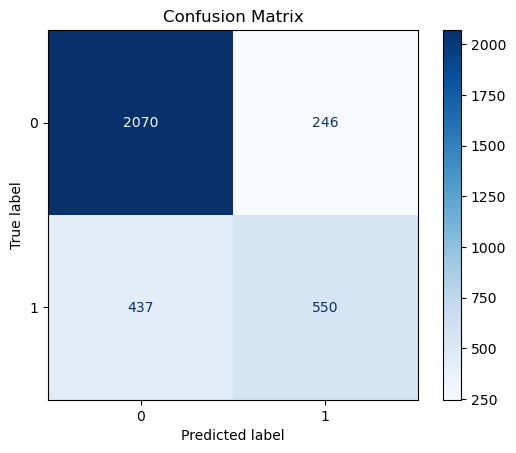

Evaluating on all
Meta-Classifier Accuracy: 0.8005
Confusion Matrix:
[[10209  1135]
 [ 2159  3008]]


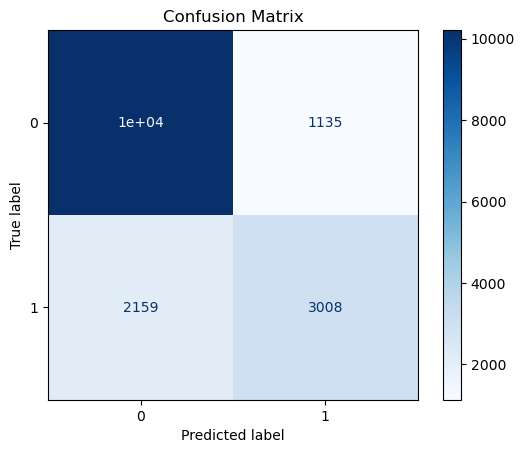

In [45]:
class MetaClassifier(nn.Module):
    def __init__(self, hidden_size=32):
        super(MetaClassifier, self).__init__()
        # Combine binary output (1 value) and multiclass output (class 0 probability)
        self.fc1 = nn.Linear(2, hidden_size)  # We combine two inputs: binary output and multiclass class-0 probability
        self.fc2 = nn.Linear(hidden_size, 1)  # Output for binary classification (0 or non-0)
    
    def forward(self, binary_logits, multiclass_logits):
        # Ensure binary logits are squeezed to a 1D tensor
        binary_logits = binary_logits.squeeze()

        # Convert multiclass logits to probabilities and take the probability of class 0
        multiclass_0_prob = F.softmax(multiclass_logits, dim=1)[:, 0].unsqueeze(1)
        
        # Combine binary output and multiclass class-0 probability
        combined = torch.cat([binary_logits.unsqueeze(1), multiclass_0_prob], dim=1)
        
        # Forward pass through meta-classifier
        x = F.relu(self.fc1(combined))
        return torch.sigmoid(self.fc2(x))  # Sigmoid activation for binary output

def train_meta_classifier(binary_model, multiclass_model, meta_model, data, labels_multiclass, subjects, num_epochs=10, lr=0.001, test_size=0.2, groups_split=True):
    # Convert labels: class 0 vs non-0 (1, 2, 3, 4)
    labels_binary = torch.FloatTensor(binary_one_hot(labels_multiclass))

    # Split data into training and testing sets
    if groups_split:
        gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
        train_idx, test_idx = next(gss.split(data, labels_multiclass, groups=subjects))
    else:
        train_idx, test_idx = train_test_split(np.arange(len(data)), test_size=test_size, random_state=42)

    # Split data and labels
    X_train, X_test = data[train_idx], data[test_idx]
    y_train_binary, y_test_binary = labels_binary[train_idx], labels_binary[test_idx]
    y_train_multi, y_test_multi = labels_multiclass[train_idx], labels_multiclass[test_idx]

    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train_binary = torch.FloatTensor(y_train_binary)
    y_test_binary = torch.FloatTensor(y_test_binary)

    # Prepare optimizer and loss function
    optimizer = optim.Adam(meta_model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Training loop
    for epoch in range(num_epochs):
        meta_model.train()
        running_loss = 0.0

        optimizer.zero_grad()

        # Get outputs from both models (disable gradients for them)
        with torch.no_grad():
            binary_logits_train = binary_model(X_train)  # Binary classification logits
            multiclass_logits_train = multiclass_model(X_train)  # Multiclass classification logits

        # Forward pass through meta-classifier
        outputs = meta_model(np.argmax(binary_logits_train, axis=1), multiclass_logits_train).squeeze()

        # Compute loss
        loss = criterion(outputs, np.argmax(y_train_binary, axis=1).float())

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss}")
    print("Evaluating on test")
    # binary_model
    evaluate_meta_classifier(binary_model, model_multi, meta_model, X_test, y_test_multi, threshold=0.5)
    # evaluate_meta_classifier(model_binary, model_multi, meta_model, X_test, y_test_multi, threshold=0.5)
    print("Evaluating on all")
    evaluate_meta_classifier(binary_model, model_multi, meta_model, data, labels_multiclass, threshold=0.5)
    # evaluate_meta_classifier(model_binary, model_multi, meta_model, data, labels_multiclass, threshold=0.5)

    
def evaluate_meta_classifier(binary_model, multiclass_model, meta_model, X_test, labels_multiclass, threshold=0.5):
    # Convert labels: class 0 vs non-0 (1, 2, 3, 4)
    labels_binary = torch.FloatTensor(binary_one_hot(labels_multiclass))
    binary_labels_num = np.argmax(labels_binary, axis=1).float()

    # Convert to tensors
    X_test = torch.FloatTensor(X_test)

    meta_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        # Get outputs from both models
        binary_logits = binary_model(X_test)
        multiclass_logits = multiclass_model(X_test)

        # Meta-classifier prediction
        outputs = meta_model(np.argmax(binary_logits, axis=1), multiclass_logits).squeeze()
        preds = (outputs > threshold).float()  # Threshold at 0.5 for binary classification

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(binary_labels_num.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Meta-Classifier Accuracy: {accuracy:.4f}")

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Step 9: Display the confusion matrix as a heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Analyze major errors by identifying misclassifications
    total_samples_per_class = np.sum(conf_matrix, axis=1)
    error_counts = np.sum(conf_matrix, axis=1) - np.diag(conf_matrix)  # Errors per class
    error_rates = error_counts / total_samples_per_class
    major_errors = np.argsort(error_rates)[::-1]  # Sort in descending order of errors

    return accuracy, conf_matrix

    # Evaluate the model after training
meta_model = MetaClassifier(hidden_size=32)

train_meta_classifier(model_binary_full, model_multi, meta_model, fft_features, all_labels, subjects, num_epochs=100, lr=0.01, test_size=0.2, groups_split=False)
